In [135]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

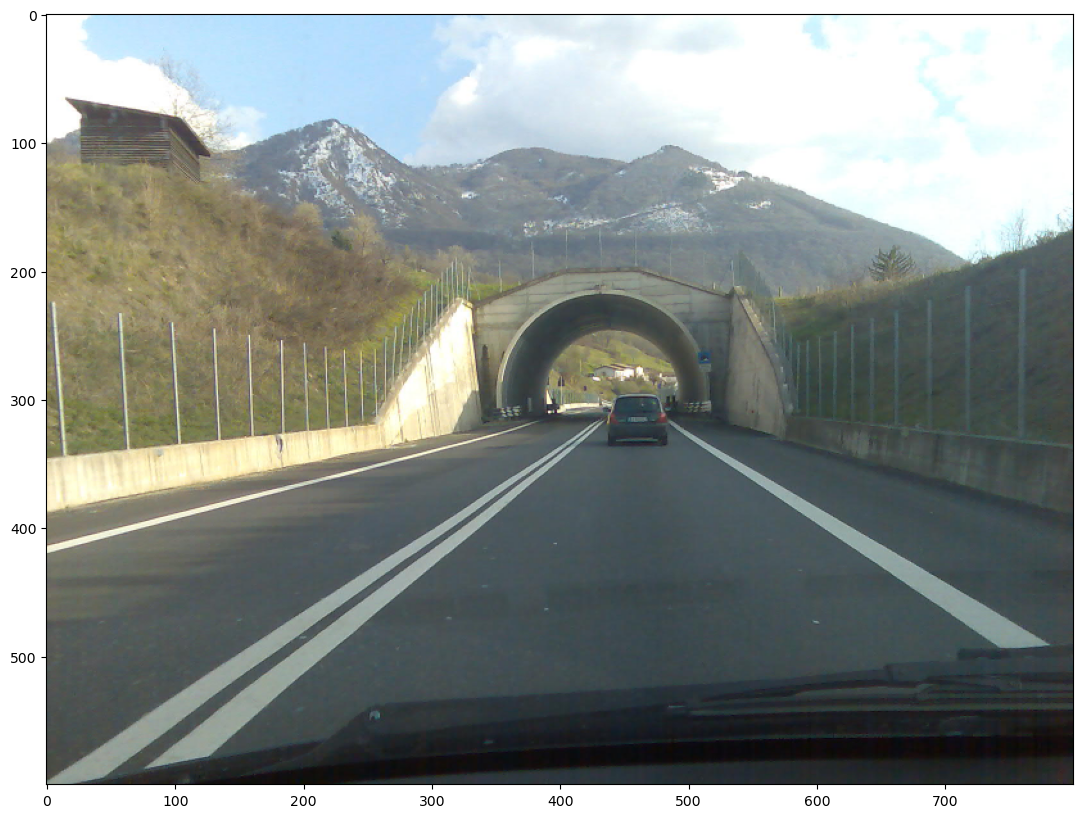

In [136]:
img = cv2.imread('dashcam.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, None, fx=0.5, fy=0.5)
plt.imshow(img)

(<Axes: >, <matplotlib.image.AxesImage at 0x2548cee4910>)

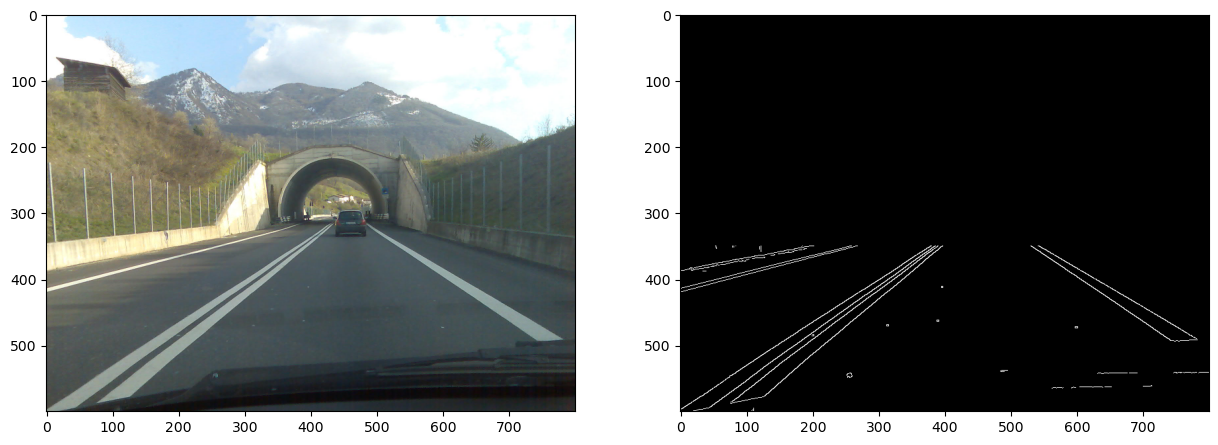

In [137]:
# Prepare gray scale image

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

edges = cv2.Canny(gray, threshold1=100, threshold2=150)
edges[0:350] = 0

plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(edges, cmap='gray')

(<Axes: >, <matplotlib.image.AxesImage at 0x2548e687290>)

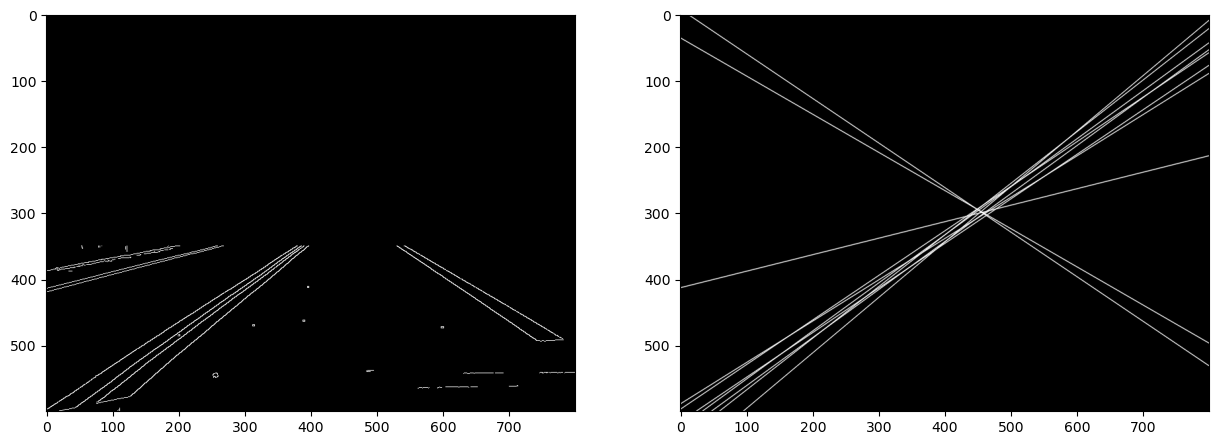

In [138]:
# Apply Hough transform to parametrize the lines
# Hint 1: Offset resolution of 2 pixels and slope resolution of 2 degrees work well in this case
# Hint 2: A suitable value for the accumulator threshold is 190

lines = cv2.HoughLines(edges, rho=2, theta=2*np.pi/180, threshold=190)

# Let's get rid of the unnecessary dimension
lines = lines[:, 0, :]
hough = np.zeros_like(edges)
    
for line in lines:
    rho = line[0]
    theta = line[1]
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    cv2.line(hough, pt1, pt2, 255, 1, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray')
plt.subplot(122), plt.imshow(hough, cmap='gray')

In [139]:
# Filter out all lines that are approximately horizontal (+/- 20 degrees). 
filtered_lines = []
for line in lines:
    # Extract theta for current line (remember Hough works with radians)
    theta =  line[1]
    # Keep line if theta is not horizontal
    if (theta < 70*math.pi/180) or (theta > 110*math.pi/180):
       filtered_lines.append(line)

(<Axes: title={'center': 'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

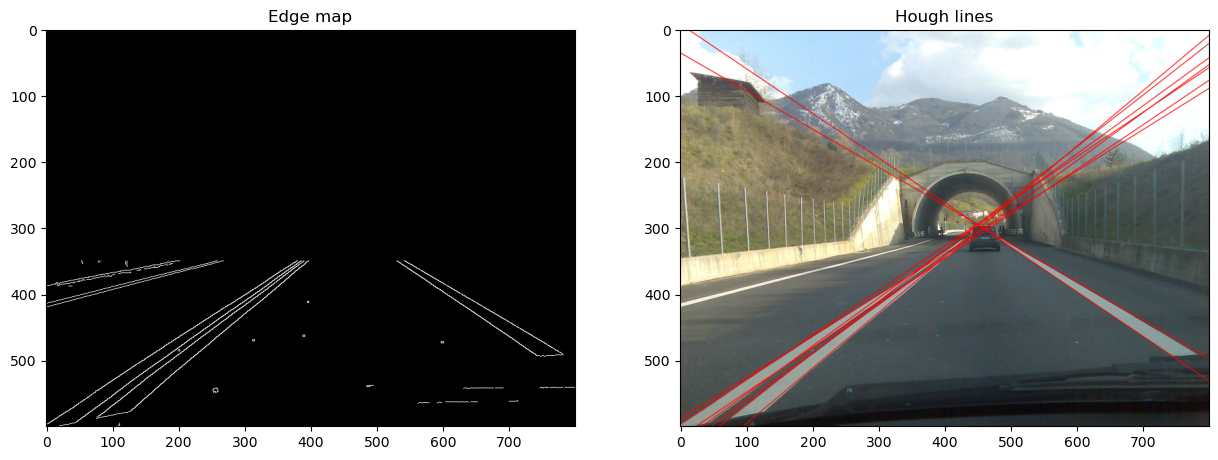

In [140]:
# Let's plot the resulting filtered lines
hough = np.copy(img)
 
for line in filtered_lines:
    rho = line[0]
    theta = line[1]
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    cv2.line(hough, pt1, pt2, 255, 1, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(hough, cmap='gray'), plt.title('Hough lines')

In [141]:
# We will apply k-means clustering to refine the detected lines.
# Don't worry, we will learn about the clustering later in the course :-)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6).fit(filtered_lines)
kmeans.cluster_centers_

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


array([[505.        ,   0.94247776],
       [ 31.        ,   2.09439516],
       [ -7.        ,   2.16420817],
       [521.        ,   0.87266463],
       [497.        ,   0.99483767],
       [511.        ,   0.94247778]])

(<Axes: title={'center': 'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

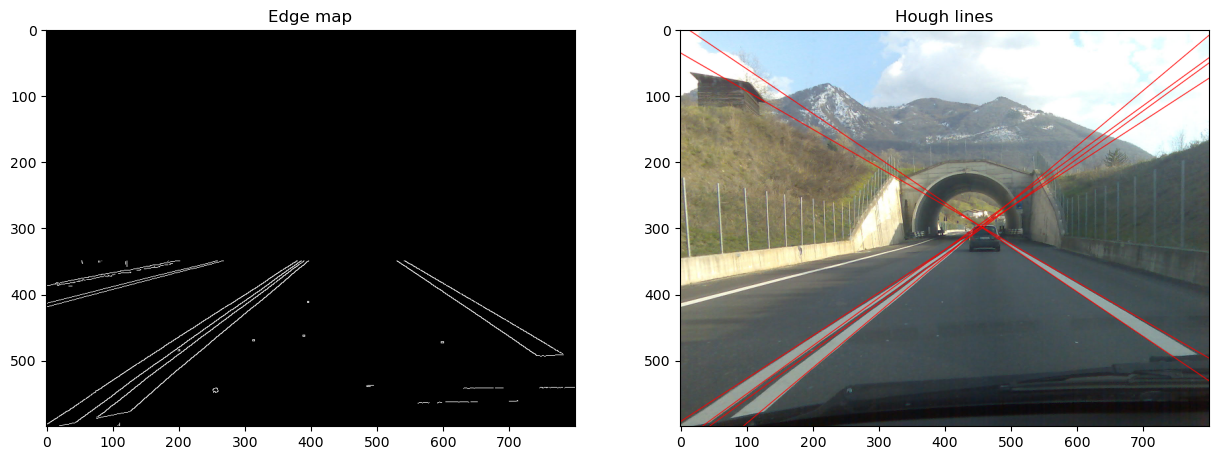

In [142]:
# Again, let's plot the resulting filtered lines
result = np.copy(img)
    
for line in kmeans.cluster_centers_:
    rho = line[0]
    theta = line[1]
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    cv2.line(result, pt1, pt2, 255, 1, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')

1. Do you see anything strange in the final result?

В цілому результат задовільний, але, так, деякі лінії, які отримані після трансформації Гафа, не співпадають чітко з реальною межою зображення. 

2. Do you think the Hough transform resolution is important for obtaining a good result? Why?

Так, це важливо.
Я перевірив, якщо покращити resolution і взяти Offset resolution = 1 pixel and slope resolution = 1 degree, то результати будуть більш якісними 
(більш точне співпадіння лінії та межі реального зображення).

3. Do you think the Hough transform accumulator threshold is important for obtaining a good result? Why?

Так, це важливо. Якщо трешхолд буде занадто низьким , то алгоритм Гафа поверне дуже високу кількість ліній (перевіряв для threshold=50), 
деякі з яких будуть по суті шумом і їх буде важче потім обробляти.
Якщо трешхолд буде занадто високим, то алгоритм Гафа може загубити одну з важливих ліній (перевіряв для threshold=250). 
Оптимальний трешхолд - це по суті компроміс між тим, щоб визначити всі релевантні лінії і тим, щоб уникнути шумів. 
Як я розумію, нема єдиної рекомендації по трешхолду, він підбирається доволі індивідуально під тип зображення
